In [1]:
# add path to explore_by_example src folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme.active_learning import *
from aideme.initial_sampling import StratifiedSampler
from aideme.explore import *
from aideme.utils.metrics import three_set_metric, classification_metrics
from aideme.utils.plotting import plot_polytope
from aideme.utils.convergence import *

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()

In [3]:
# DUMMY DATA
N = int(1e5)
dim = 2
limit = 2 * (0.001)**(1. / dim)
X = np.random.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y_subspace = np.vstack([np.abs(X[:, i]) < limit for i in range(dim)]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.089 %


# NO FACTORIZATION EXAMPLE

iter: 1, fscore: 0.0024698895487595047, tsm: 0.0
iter: 11, fscore: 0.20578034682080926, tsm: 0.0
iter: 21, fscore: 0.47058823529411764, tsm: 0.0
iter: 31, fscore: 0.7745098039215687, tsm: 0.0008827238335435057
iter: 41, fscore: 0.9120879120879121, tsm: 0.20224719101123595
iter: 51, fscore: 0.9405405405405406, tsm: 0.3761904761904762
iter: 61, fscore: 0.9710982658959537, tsm: 0.5985401459854015
iter: 71, fscore: 0.9943502824858758, tsm: 0.8073394495412844
iter: 81, fscore: 1.0, tsm: 0.9888888888888889


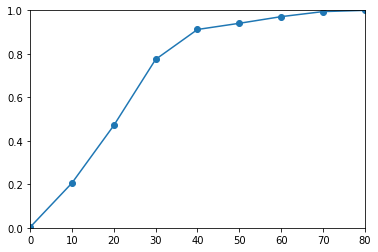

In [5]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user
SUBSAMPLING = float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)  # start with one random positive sample and one random negative sample
CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics('fscore'), 
    three_set_metric,
]
CALLBACK_SKIP = 10
PRINT_CALLBACK_RESULT = True
CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #all_points_are_known,
    #metric_reached_threshold('fscore', 0.8),
    metric_reached_threshold('tsm', 0.9),
]

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT, CONVERGENCE_CRITERIA)

# CHOOSE AN ALGORITHM
#learner = RandomSampler(SVC(C=1e5, kernel='rbf', gamma='auto'))  # choose a random point
learner = SimpleMargin(C=1024, kernel='rbf', gamma=5)  # choose point closest to SVM decision boundary
#learner = KernelQueryByCommittee(kernel='rbf', sampling='deterministic', n_samples=8, warmup=1000, thin=100, rounding=True)  # version space algorithm
learner = DualSpaceModel(learner, sample_unknown_proba=0.5, mode='positive')  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y, learner, repeat=1)  # 'repeat' specifies how many times to repeat the exploration process

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
plot_fscore(metrics)

# FACTORIZATION EXAMPLE

iter: 1, fscore: 0.0026433026433026435, tsm: 0.0
iter: 11, fscore: 0.6060606060606061, tsm: 0.0
iter: 21, fscore: 0.8148148148148148, tsm: 0.3076923076923077
iter: 31, fscore: 0.9333333333333333, tsm: 0.7254901960784313
iter: 41, fscore: 1.0, tsm: 0.9777777777777777
iter: 51, fscore: 1.0, tsm: 1.0


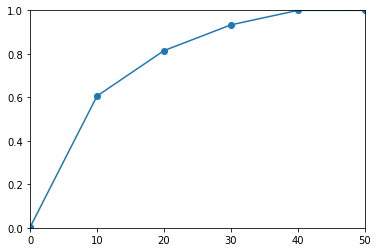

In [9]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user
SUBSAMPLING = float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)  # start with one random positive sample and one random negative sample
CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics('fscore'), 
    three_set_metric,
]
CALLBACK_SKIP = 10
PRINT_CALLBACK_RESULT = True
CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #metric_reached_threshold('fscore', 0.8),
    metric_reached_threshold('tsm', 0.9),
]

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT, CONVERGENCE_CRITERIA)

# Factorized AL algorithms
PARTITION = [[i] for i in range(dim)]  #[[0], [1]]

# FACTORIZED VERSION SPACE
# label_function = 'AND', 'OR', 'PROD'
# loss = 'GREEDY', 'SQUARED', 'PRODUCT'
#learner = SubspatialVersionSpace(warmup=100, thin=10, n_samples=8, rounding=True, kernel='rbf', gamma=None, partition=PARTITION, label_function='AND', loss='GREEDY')

# FACTORIZED SIMPLE MARGIN
#learner = SubspatialSimpleMargin(C=1024, kernel='rbf', gamma=5, partition=PARTITION, label_function='AND')

# FACTORIZED DSM
learner = DualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), mode='positive', sample_unknown_proba=0.5, partition=PARTITION)  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y_subspace, learner, repeat=1)  # use y_subspace here

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
plot_fscore(metrics)